In [153]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import optimizers
from keras.models import Sequential
from keras.layers import LSTM,Dropout,Dense,Input,Activation
from keras.models import Model

%matplotlib inline

In [154]:
df_FPT = pd.read_csv('./data/FPT.csv')
df_MSN = pd.read_csv('./data/MSN.csv')
df_PNJ = pd.read_csv('./data/PNJ.csv')
df_VIC = pd.read_csv('./data/VIC.csv')

In [155]:
df_FPT['Date/Time'] = pd.to_datetime(df_FPT['Date/Time'], format='%m/%d/%Y %H:%M')
df_MSN['Date/Time'] = pd.to_datetime(df_MSN['Date/Time'], format='%m/%d/%Y %H:%M')
df_PNJ['Date/Time'] = pd.to_datetime(df_PNJ['Date/Time'], format='%m/%d/%Y %H:%M')
df_VIC['Date/Time'] = pd.to_datetime(df_VIC['Date/Time'], format='%m/%d/%Y %H:%M')

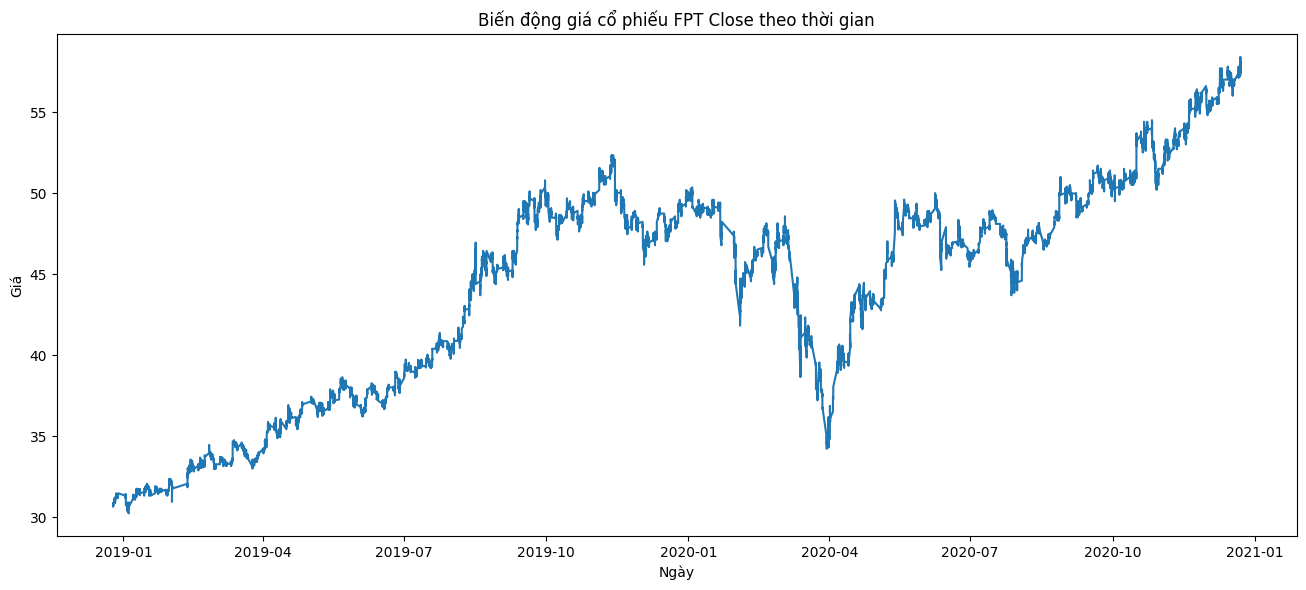

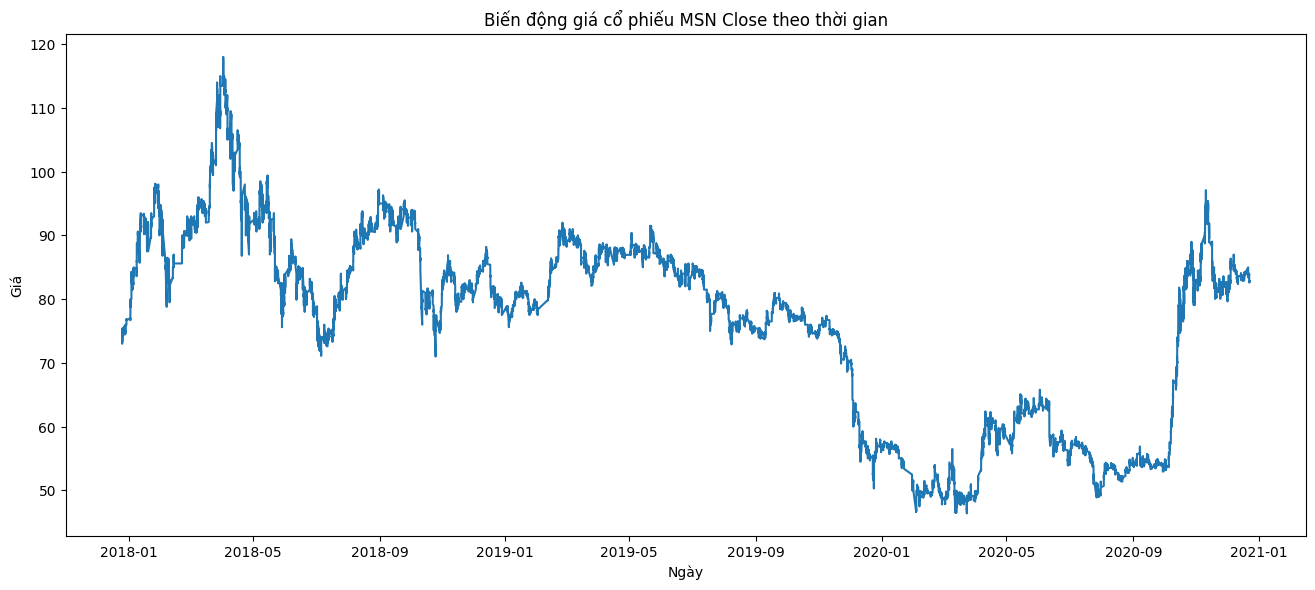

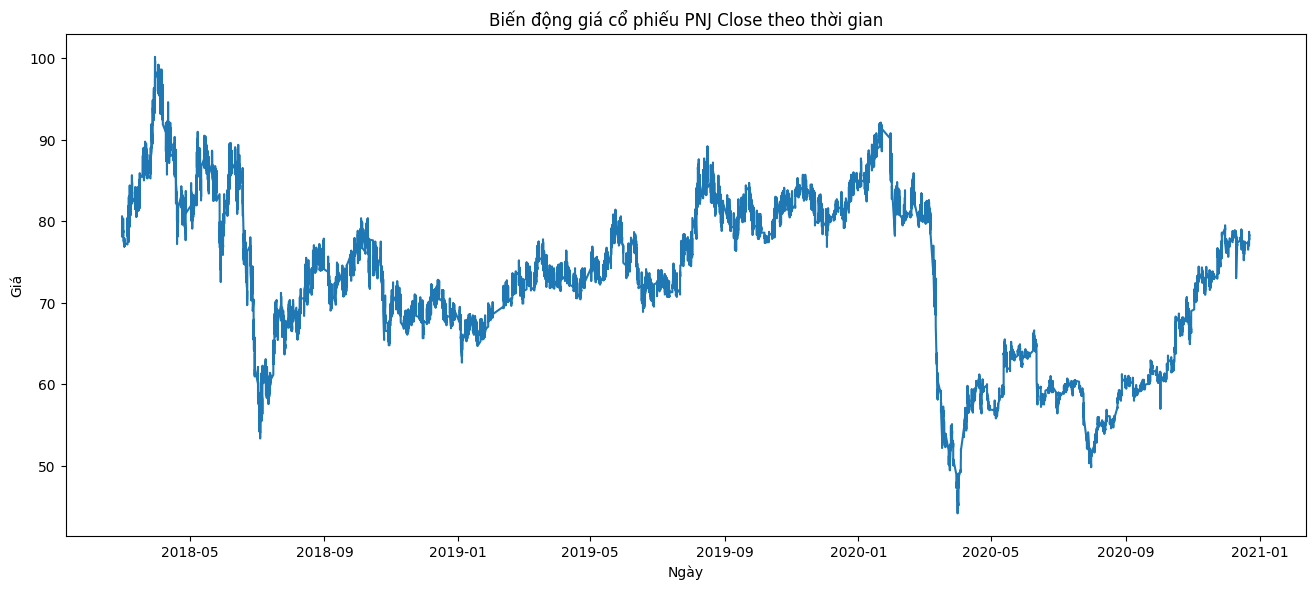

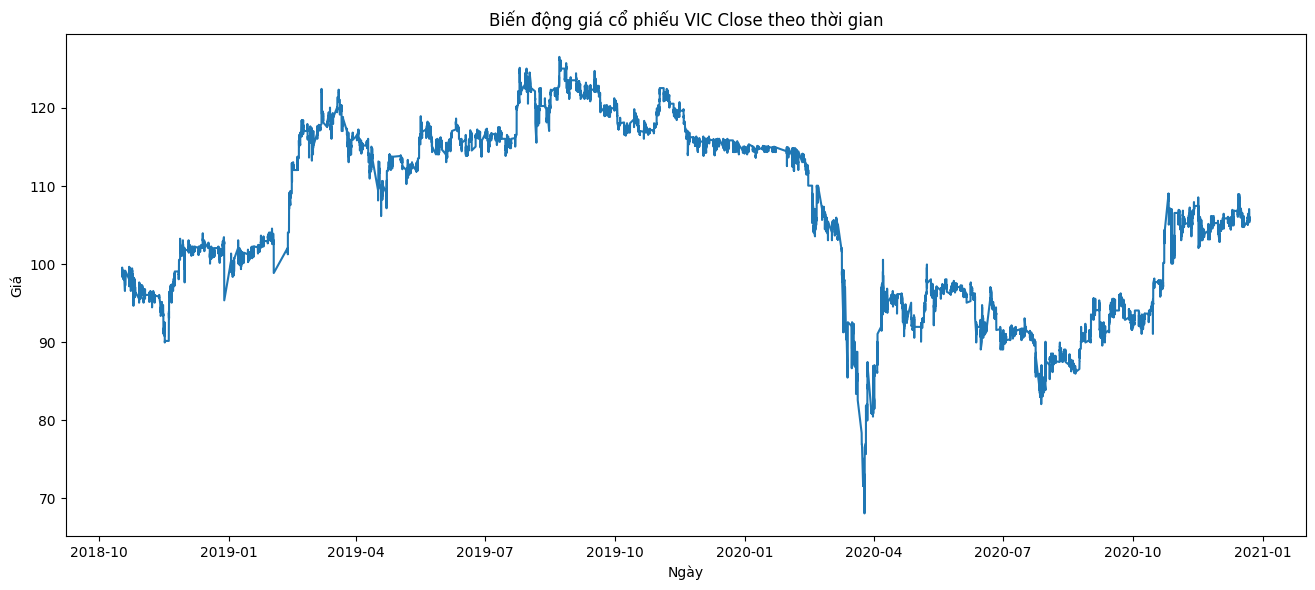

In [156]:
list_df = [df_FPT,df_MSN,df_PNJ,df_VIC]
for i, df in enumerate(list_df):
    plt.figure(figsize = (16,30))
    plt.subplot(4,1,i+1)
    plt.plot(df['Date/Time'], df['Close'])
    plt.title(f'Biến động giá cổ phiếu {df.Ticker[0]} Close theo thời gian')
    plt.xlabel('Ngày')
    plt.ylabel('Giá')
    plt.show()


In [157]:
def Split_train_test(df,backcandles=50,epochs = 4,batch_size = 15):
#___ với df là dataframe đưa vào, backcandles mặc định = 50 là số lượng giá trị input trong quá khứ để đưa vào dự đoán giá trị hiện tại
#Xử lý dữ liệu
    #Thêm cột TargetNextClose với giá trị là giá đóng cửa tiếp theo của phiên ghi nhận 
    df['TargetNextClose'] = df['Close'].shift(-1)
    #Bỏ các giá trị nan
    df.dropna(inplace=True)
    #Drop các cột Ticker, OpenInterest, Date/Time để dataframe chỉ chứa các giá trị cần thiết có thể xử lý
    #['Open','High','Low','Close','Volume']
    df.drop(['Ticker','Open Interest','Date/Time'],axis=1,inplace=True)
    #Scale lại các giá trị của df [0,1]
    sc = MinMaxScaler(feature_range=(0,1))
    dataset_scaled = sc.fit_transform(df)
    
    
    # Chia tập train_test
    X=[]
    for j in range(5):
        X.append([])
        for i in range(backcandles,dataset_scaled.shape[0]):
            X[j].append(dataset_scaled[i-backcandles:i,j])
    X = np.moveaxis(X,[0],[2])    # X.shape = (len(df), backcandles, 5)
    X,yi = np.array(X) , np.array(dataset_scaled[backcandles:,-1])
    y = np.reshape(yi,(len(yi),1))   # y.shape = (len(df), 1)
    
    
    splitlimit = int(len(X)*0.8) # chia train_size = 0.8
    X_train,X_test = X[:splitlimit], X[splitlimit:]
    y_train,y_test = y[:splitlimit], y[splitlimit:]
# Tạo model LSTM dự đoán và đưa ra giá trị predict
    np.random.seed(10)

    lstm_input = Input(shape=(backcandles, 5), name='lstm_input')
    inputs = LSTM(150, name='first_layer')(lstm_input)
    inputs = Dense(1, name='dense_layer')(inputs)
    output = Activation('linear', name='output')(inputs)
    model = Model(inputs=lstm_input, outputs=output)
    adam = optimizers.Adam()
    model.compile(optimizer=adam, loss='mse')
    model.fit(x=X_train, y=y_train, batch_size=15, epochs=epochs, shuffle=True, validation_split = 0.1)
    print('\n',model.summary())
    
    y_pred = model.predict(X_test)
    #invert transform lại giá trị dự đoán
    y_inverted_pred = y_pred * (df['Close'].max() - df['Close'].min()) + df['Close'].min()
    y_inverted_test = y_test * (df['Close'].max() - df['Close'].min()) + df['Close'].min()
    return y_inverted_pred, y_inverted_test

### df_FPT

Epoch 1/4
4673/4673 [==============================] - 30s 6ms/step - loss: 1.7010e-04 - val_loss: 7.0406e-05
Epoch 2/4
4673/4673 [==============================] - 28s 6ms/step - loss: 1.8588e-05 - val_loss: 8.0191e-06
Epoch 3/4
4673/4673 [==============================] - 28s 6ms/step - loss: 1.4526e-05 - val_loss: 1.5745e-05
Epoch 4/4
4673/4673 [==============================] - 28s 6ms/step - loss: 1.2637e-05 - val_loss: 9.2647e-06
Model: "model_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_input (InputLayer)     [(None, 50, 5)]           0         
                                                                 
 first_layer (LSTM)          (None, 150)               93600     
                                                                 
 dense_layer (Dense)         (None, 1)                 151       
                                                                 
 output (Activa

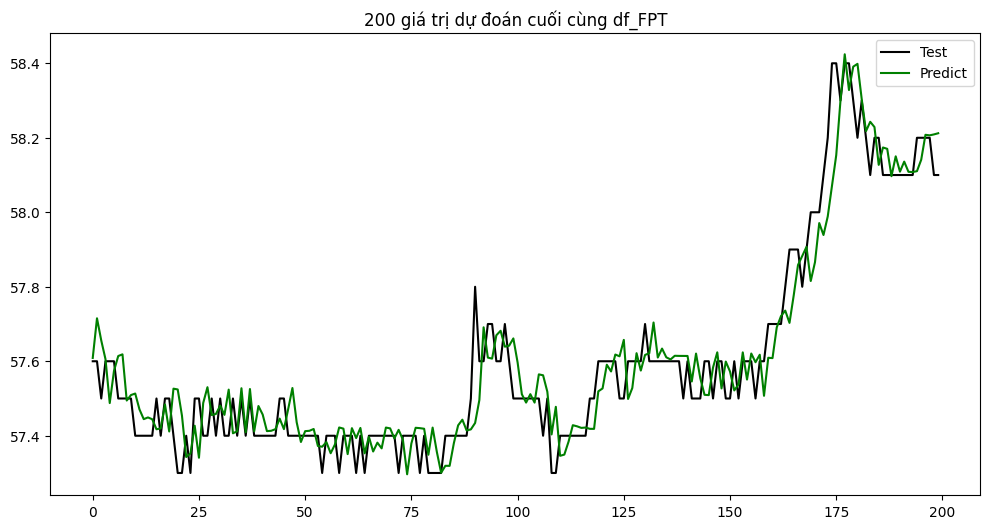

In [158]:
df_FPT = pd.read_csv('./data/FPT.csv')
y_inverted_pred,y_inverted_test = Split_train_test(df_FPT,backcandles=50)
plt.figure(figsize=(12,6))
plt.plot(y_inverted_test[-200:], color = 'black', label = 'Test')
plt.plot(y_inverted_pred[-200:], color = 'green', label = 'Predict')
plt.legend()
plt.title('200 giá trị dự đoán cuối cùng df_FPT')
plt.show()

### df_MSN

Epoch 1/4
6495/6495 [==============================] - 40s 6ms/step - loss: 1.1608e-04 - val_loss: 5.6781e-06
Epoch 2/4
6495/6495 [==============================] - 37s 6ms/step - loss: 1.9041e-05 - val_loss: 1.0251e-05
Epoch 3/4
6495/6495 [==============================] - 37s 6ms/step - loss: 1.7032e-05 - val_loss: 4.2682e-06
Epoch 4/4
6495/6495 [==============================] - 37s 6ms/step - loss: 1.6357e-05 - val_loss: 4.0891e-06
Model: "model_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_input (InputLayer)     [(None, 40, 5)]           0         
                                                                 
 first_layer (LSTM)          (None, 150)               93600     
                                                                 
 dense_layer (Dense)         (None, 1)                 151       
                                                                 
 output (Activa

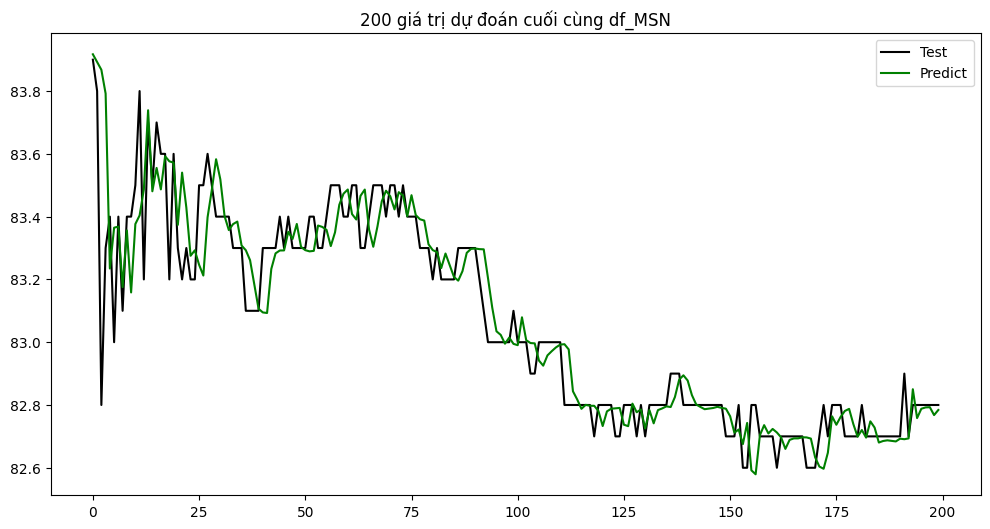

In [159]:
df_MSN = pd.read_csv('./data/MSN.csv')
y_inverted_pred,y_inverted_test = Split_train_test(df_MSN,backcandles=40)
plt.figure(figsize=(12,6))
plt.plot(y_inverted_test[-200:], color = 'black', label = 'Test')
plt.plot(y_inverted_pred[-200:], color = 'green', label = 'Predict')
plt.legend()
plt.title('200 giá trị dự đoán cuối cùng df_MSN')
plt.show()

### df_PNJ

Epoch 1/4
6011/6011 [==============================] - 55s 9ms/step - loss: 3.0128e-04 - val_loss: 4.3374e-05
Epoch 2/4
6011/6011 [==============================] - 55s 9ms/step - loss: 1.5808e-04 - val_loss: 1.1781e-05
Epoch 3/4
6011/6011 [==============================] - 55s 9ms/step - loss: 1.5347e-04 - val_loss: 1.7764e-05
Epoch 4/4
6011/6011 [==============================] - 55s 9ms/step - loss: 1.4757e-04 - val_loss: 8.0005e-06
Model: "model_8"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_input (InputLayer)     [(None, 80, 5)]           0         
                                                                 
 first_layer (LSTM)          (None, 150)               93600     
                                                                 
 dense_layer (Dense)         (None, 1)                 151       
                                                                 
 output (Activa

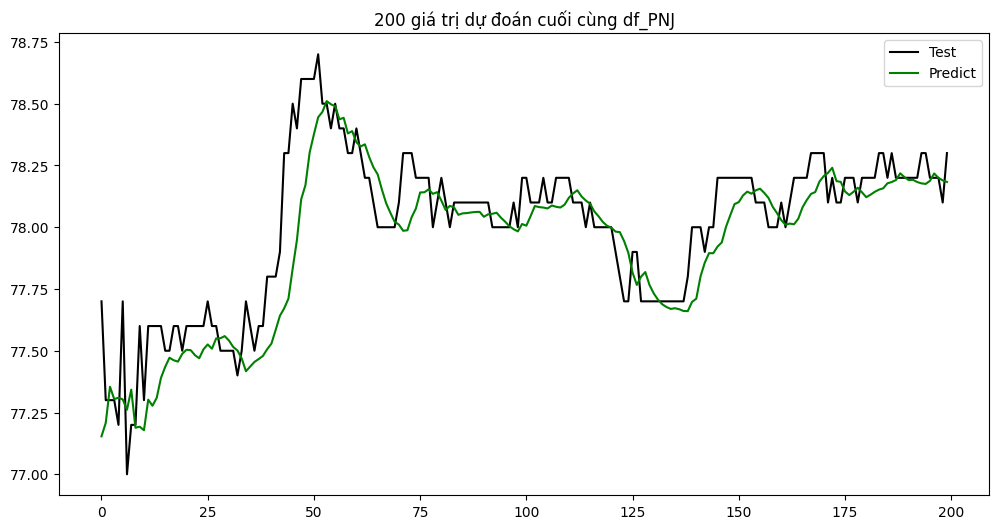

In [164]:
df_PNJ = pd.read_csv('./data/PNJ.csv')
y_inverted_pred,y_inverted_test = Split_train_test(df_PNJ,backcandles=80)
plt.figure(figsize=(12,6))
plt.plot(y_inverted_test[-200:], color = 'black', label = 'Test')
plt.plot(y_inverted_pred[-200:], color = 'green', label = 'Predict')
plt.legend()
plt.title('200 giá trị dự đoán cuối cùng df_PNJ')
plt.show()


### df_VIC

Epoch 1/4
4858/4858 [==============================] - 42s 9ms/step - loss: 3.1024e-04 - val_loss: 2.1185e-05
Epoch 2/4
4858/4858 [==============================] - 41s 8ms/step - loss: 3.0105e-05 - val_loss: 2.0071e-05
Epoch 3/4
4858/4858 [==============================] - 41s 8ms/step - loss: 2.5133e-05 - val_loss: 1.5944e-05
Epoch 4/4
4858/4858 [==============================] - 41s 8ms/step - loss: 2.2321e-05 - val_loss: 1.4886e-05
Model: "model_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_input (InputLayer)     [(None, 70, 5)]           0         
                                                                 
 first_layer (LSTM)          (None, 150)               93600     
                                                                 
 dense_layer (Dense)         (None, 1)                 151       
                                                                 
 output (Activa

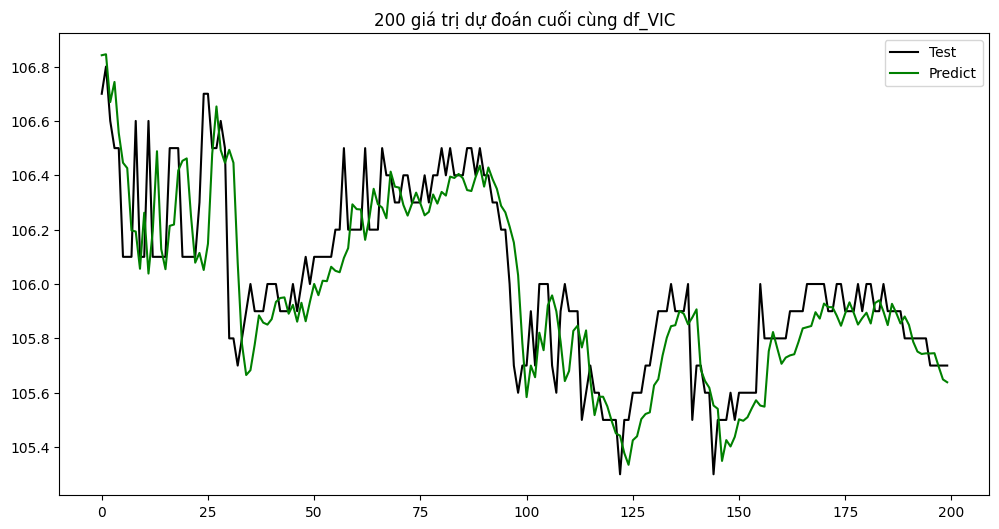

In [161]:
df_VIC = pd.read_csv('./data/VIC.csv')
y_inverted_pred,y_inverted_test = Split_train_test(df_VIC,backcandles=70)
plt.figure(figsize=(12,6))
plt.plot(y_inverted_test[-200:], color = 'black', label = 'Test')
plt.plot(y_inverted_pred[-200:], color = 'green', label = 'Predict')
plt.legend()
plt.title('200 giá trị dự đoán cuối cùng df_VIC')
plt.show()